<h2>Introduction</h2>

In this exercise, you'll build a model to predict hotel cancellations with a binary classifier.

In [1]:
# Setup plotting
import matplotlib.pyplot as plt

In [2]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

hotel = pd.read_csv('../hotel.csv')

X = hotel.copy()
y = X.pop('is_canceled')

X['arrival_date_month'] = \
    X['arrival_date_month'].map(
        {'January':1, 'February': 2, 'March':3,
         'April':4, 'May':5, 'June':6, 'July':7,
         'August':8, 'September':9, 'October':10,
         'November':11, 'December':12}
    )

features_num = [
    "lead_time", "arrival_date_week_number",
    "arrival_date_day_of_month", "stays_in_weekend_nights",
    "stays_in_week_nights", "adults", "children", "babies",
    "is_repeated_guest", "previous_cancellations",
    "previous_bookings_not_canceled", "required_car_parking_spaces",
    "total_of_special_requests", "adr",
]
features_cat = [
    "hotel", "arrival_date_month", "meal",
    "market_segment", "distribution_channel",
    "reserved_room_type", "deposit_type", "customer_type",
]

transformer_num = make_pipeline(
    SimpleImputer(strategy="constant"), # there are a few missing values
    StandardScaler(),
)
transformer_cat = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown='ignore'),
)

preprocessor = make_column_transformer(
    (transformer_num, features_num),
    (transformer_cat, features_cat),
)

# stratify - make sure classes are evenlly represented across splits
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.75)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)

input_shape = [X_train.shape[1]]

<h3>1) Define Model</h3>
The model we'll use this time will have both batch normalization and dropout layers. To ease reading we've broken the diagram into blocks, but you can define it layer by layer as usual.

Define a model with an architecture given by this diagram:

<figure style="padding: 1em;">
<img src="https://storage.googleapis.com/kaggle-media/learn/images/V04o59Z.png" width="400" alt="Diagram of network architecture: BatchNorm, Dense, BatchNorm, Dropout, Dense, BatchNorm, Dropout, Dense.">
<figcaption style="textalign: center; font-style: italic"><center>Diagram of a binary classifier.</center></figcaption>
</figure>

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

model = keras.Sequential([
    keras.Input(shape=input_shape),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
])

<h3>2) Add Optimizer, Loss, and Metric</h3>

Now compile the model with the Adam optimizer and binary versions of the cross-entropy loss and accuracy metric.

In [4]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

Finally, run this cell to train the model and view the learning curves. It may run for around 60 to 70 epochs, which could take a minute or two.

Epoch 1/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - binary_accuracy: 0.7425 - loss: 0.5323 - val_binary_accuracy: 0.8067 - val_loss: 0.4340
Epoch 2/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.7986 - loss: 0.4273 - val_binary_accuracy: 0.8146 - val_loss: 0.4009
Epoch 3/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8073 - loss: 0.4095 - val_binary_accuracy: 0.8173 - val_loss: 0.3930
Epoch 4/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8101 - loss: 0.4023 - val_binary_accuracy: 0.8190 - val_loss: 0.3893
Epoch 5/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - binary_accuracy: 0.8150 - loss: 0.3952 - val_binary_accuracy: 0.8192 - val_loss: 0.3853
Epoch 6/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_accuracy: 0.8172 - loss: 0.3930 - val_binary_accuracy: 0.8255 - val_loss: 0.3822
Epoch 7/200
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - binary_accuracy: 0.8195 - loss: 0.3881 - val_binary_accuracy: 0.8257 - val_loss: 0.379

<Axes: title={'center': 'Accuracy'}>

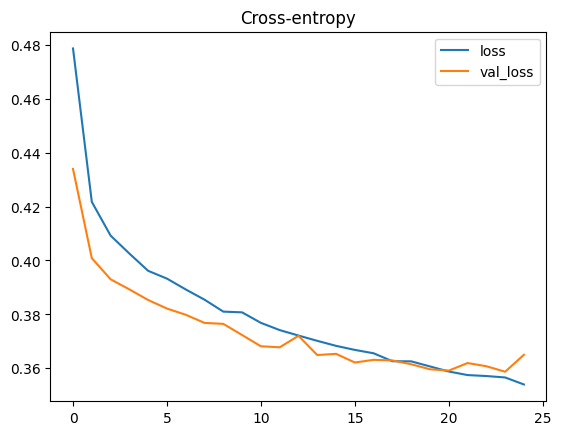

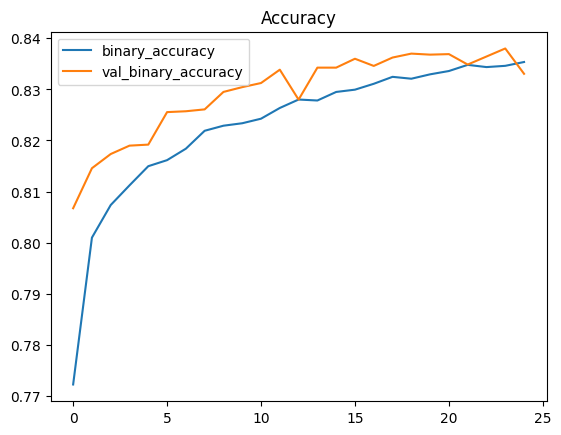

In [5]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

<h3>3) Train and Evaluate</h3>

What do you think about the learning curves? Does it look like the model underfit or overfit? Was the cross-entropy loss a good stand-in for accuracy?